题目：

构造一个数据集，有5组数据，满足混合高斯模型，用HMM去拟合参数。

## 1.导入库

In [27]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics.pairwise import pairwise_distances_argmin
import warnings

## 2.构造数据集

In [28]:
def expand(a, b):
    d = (b - a) * 0.05
    return a-d, b+d

In [29]:
# 避免提出警告，没什么用
warnings.filterwarnings("ignore")   # hmmlearn(0.2.0) < sklearn(0.18)
np.random.seed(0)

构造数据

In [30]:
n = 5    # 隐状态数目
n_samples = 1000
pi = np.random.rand(n)
pi /= pi.sum()  # 初始概率 pi
print ('初始概率：', pi)

初始概率： [0.19356424 0.25224431 0.21259213 0.19217803 0.14942128]


为了可以成为五角星，设置一个状态只能转移到其他2个状态

In [31]:
# 设定状态转移概率
A = np.random.rand(n, n)
mask = np.zeros((n, n), dtype=np.bool)
mask[0][1] = mask[0][4] = True
mask[1][0] = mask[1][2] = True
mask[2][1] = mask[2][3] = True
mask[3][2] = mask[3][4] = True
mask[4][0] = mask[4][3] = True
A[mask] = 0
for i in range(n):
    A[i] /= A[i].sum()
print ('转移概率：\n', A)

转移概率：
 [[0.25822029 0.         0.35651955 0.38526017 0.        ]
 [0.         0.34669639 0.         0.6067387  0.04656491]
 [0.04868208 0.         0.46521279 0.         0.48610513]
 [0.3825259  0.31237801 0.         0.30509609 0.        ]
 [0.         0.09539815 0.62865435 0.         0.2759475 ]]


In [32]:
# 给定均值
means = np.array(((30, 30), (0, 50), (-25, 30), (-15, 0), (15, 0)))
print ('均值：\n', means)

均值：
 [[ 30  30]
 [  0  50]
 [-25  30]
 [-15   0]
 [ 15   0]]


In [33]:
# 给定方差
covars = np.empty((n, 2, 2))
for i in range(n):
    # covars[i] = np.diag(np.random.randint(1, 5, size=2))
    covars[i] = np.diag(np.random.rand(2) * 0.3 + 0.001)*10    # np.random.rand ∈[0,1) ；方差*0.3为了是数据更离散，便于分类
print ('方差：\n', covars)

方差：
 [[[0.80366684 0.        ]
  [0.         2.33270107]]

 [[1.378451   0.        ]
  [0.         1.71530185]]

 [[0.0663694  0.        ]
  [0.         1.86290649]]

 [[1.84628717 0.        ]
  [0.         1.86080199]]

 [[2.84124424 0.        ]
  [0.         2.0554609 ]]]


## 3.模型拟合与预测

In [34]:
model = hmm.GaussianHMM(n_components=n, covariance_type='full')  # 使用库函数
model.startprob_ = pi
model.transmat_ = A
model.means_ = means
model.covars_ = covars
# X 就是sample ，Y 就是labels ，我们只用sample将其假设成为为监督学习，最后用labels去检测准确率
sample, labels = model.sample(n_samples=n_samples, random_state=0) 

In [35]:
# 估计参数
model = hmm.GaussianHMM(n_components=n, covariance_type='full', n_iter=10)
model = model.fit(sample)
y = model.predict(sample)
np.set_printoptions(suppress=True)
print ('##估计初始概率：', model.startprob_)
print('********************************************************************************************')
print ('##估计转移概率：\n', model.transmat_)
print('********************************************************************************************')
print ('##估计均值：\n', model.means_)
print('********************************************************************************************')
print ('##估计方差：\n', model.covars_)

##估计初始概率： [0. 0. 1. 0. 0.]
********************************************************************************************
##估计转移概率：
 [[0.36082474 0.03092784 0.         0.60824742 0.        ]
 [0.10071942 0.26978417 0.6294964  0.         0.        ]
 [0.         0.48905109 0.47688564 0.         0.03406326]
 [0.27642276 0.         0.         0.28455285 0.43902439]
 [0.         0.         0.43333333 0.32222222 0.24444444]]
********************************************************************************************
##估计均值：
 [[ -0.33151185  49.98276566]
 [ 14.96925071  -0.06175244]
 [-25.01752737  30.05832919]
 [-14.91004345   0.02788946]
 [ 30.03516561  30.12248569]]
********************************************************************************************
##估计方差：
 [[[ 1.23494334  0.01148405]
  [ 0.01148405  1.35077513]]

 [[ 2.36531773 -0.05062351]
  [-0.05062351  1.90165272]]

 [[ 0.0615622   0.00820638]
  [ 0.00820638  1.6420642 ]]

 [[ 1.88313434 -0.14924005]
  [-0.14924005  1.87280138

In [36]:
# 类别
order = pairwise_distances_argmin(means, model.means_, metric='euclidean')
print (order)
pi_hat = model.startprob_[order]
A_hat = model.transmat_[order]
A_hat = A_hat[:, order]
means_hat = model.means_[order]
covars_hat = model.covars_[order]
change = np.empty((n, n_samples), dtype=np.bool)
for i in range(n):
    change[i] = y == order[i]
for i in range(n):
    y[change[i]] = i
print ('估计初始概率：', pi_hat)
print('********************************************************************************************')
print ('估计转移概率：\n', A_hat)
print('********************************************************************************************')
print ('估计均值：\n', means_hat)
print('********************************************************************************************')
print ('估计方差：\n', covars_hat)
print('********************************************************************************************')
print (labels)
print('********************************************************************************************')
print (y)

[4 0 2 3 1]
估计初始概率： [0. 0. 1. 0. 0.]
********************************************************************************************
估计转移概率：
 [[0.24444444 0.         0.43333333 0.32222222 0.        ]
 [0.         0.36082474 0.         0.60824742 0.03092784]
 [0.03406326 0.         0.47688564 0.         0.48905109]
 [0.43902439 0.27642276 0.         0.28455285 0.        ]
 [0.         0.10071942 0.6294964  0.         0.26978417]]
********************************************************************************************
估计均值：
 [[ 30.03516561  30.12248569]
 [ -0.33151185  49.98276566]
 [-25.01752737  30.05832919]
 [-14.91004345   0.02788946]
 [ 14.96925071  -0.06175244]]
********************************************************************************************
估计方差：
 [[[ 0.80166474  0.14272046]
  [ 0.14272046  2.56229425]]

 [[ 1.23494334  0.01148405]
  [ 0.01148405  1.35077513]]

 [[ 0.0615622   0.00820638]
  [ 0.00820638  1.6420642 ]]

 [[ 1.88313434 -0.14924005]
  [-0.14924005  1.8728

预测准确率

In [37]:
acc = np.mean(labels == y) * 100
print ('准确率：%.2f%%' % acc)

准确率：100.00%


## 4.画图

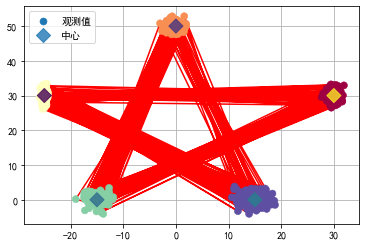

In [38]:
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.scatter(sample[:, 0], sample[:, 1], s=50, c=labels, cmap=plt.cm.Spectral, marker='o',
            label=u'观测值', linewidths=0.5, zorder=20)
plt.plot(sample[:, 0], sample[:, 1], 'r-', zorder=10)
plt.scatter(means[:, 0], means[:, 1], s=100, c=np.random.rand(n), marker='D', label=u'中心', alpha=0.8, zorder=30)
x1_min, x1_max = sample[:, 0].min(), sample[:, 0].max()
x2_min, x2_max = sample[:, 1].min(), sample[:, 1].max()
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.legend(loc='upper left')
plt.grid(True)
plt.show()